In [1]:
from traffic import rho_red_light, computeF

In [2]:
help(rho_red_light)

Help on function rho_red_light in module traffic:

rho_red_light(nx, rho_max, rho_in)
    Computes "red light" initial condition with shock
    
    Parameters
    ----------
    nx        : int
        Number of grid points in x
    rho_max   : float
        Maximum allowed car density
    rho_in    : float
        Density of incoming cars 
    
    Returns
    -------
    rho: array of floats
        Array with initial values of density



In [3]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family']='serif'
rcParams['font.size']=16
from matplotlib import animation
from JSAnimation.IPython_display import display_animation

In [4]:
nx = 101
nt = 30
dx = 4.0/(nx-2)
rho_in = 5.
rho_max = 10.
V_max = 1.
x = numpy.linspace(0,4,nx-1)
rho = rho_red_light(nx-1,rho_max,rho_in)

In [5]:
def animate(data):
    x = numpy.linspace(0,4,nx-1)
    y = data
    line.set_data(x,y)
    return line,

In [6]:
def godunov(rho,nt,dt,dx,rho_max,V_max):
    rho_n = numpy.zeros((nt,len(rho)))
    rho_n[:,:]=rho.copy()
    
    rho_plus = numpy.zeros_like(rho)
    rho_minus = numpy.zeros_like(rho)
    flux = numpy.zeros_like(rho)
    
    for t in range(1,nt):
        rho_plus[:-1]= rho[1:]
        rho_minus=rho.copy()
        flux = 0.5*(computeF(V_max,rho_max,rho_minus)+\
                    computeF(V_max,rho_max,rho_plus) +\
                    dx/dt*(rho_minus-rho_plus))
        rho_n[t,1:-1]=rho[1:-1] + dt/dx*(flux[:-2]-flux[1:-1])
        rho_n[t,0]=rho[0]
        rho_n[t,-1]=rho[-1]
        rho = rho_n[t].copy()
    return rho_n

In [7]:
sigma = 1.0
dt= sigma*dx/V_max
rho = rho_red_light(nx-1,rho_max,rho_in)
rho_n = godunov(rho,nt,dt,dx,rho_max,V_max)


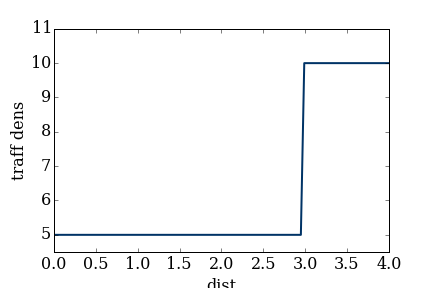
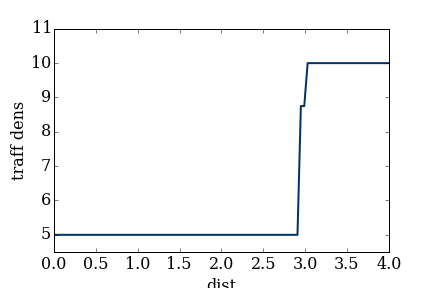
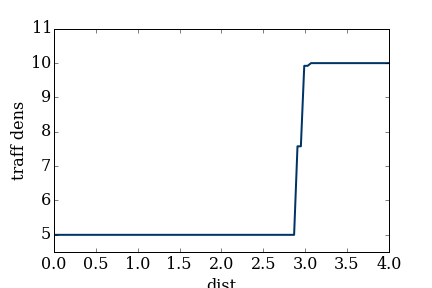
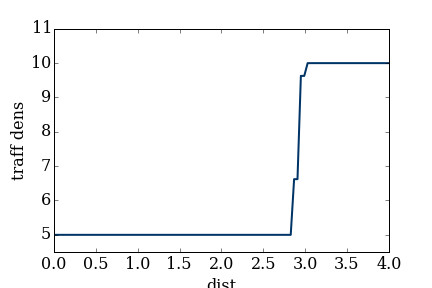
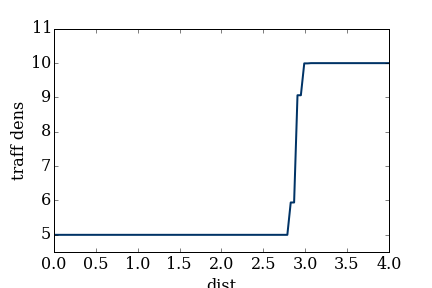
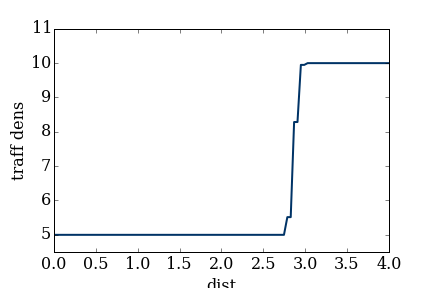
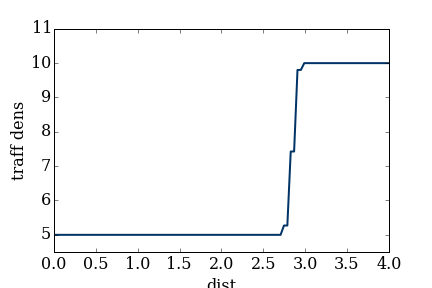
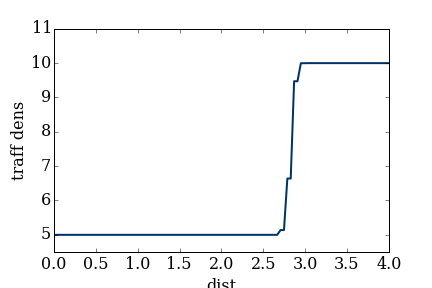
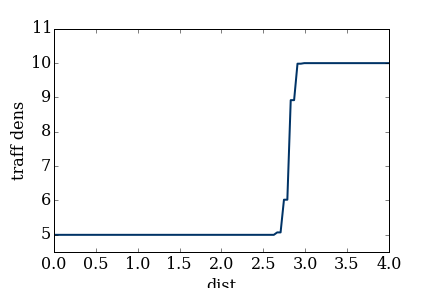
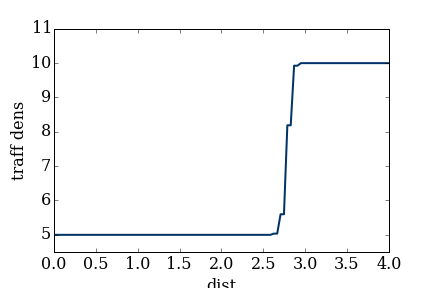
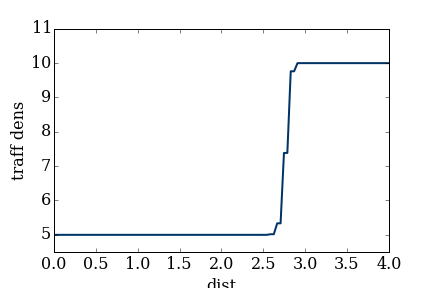
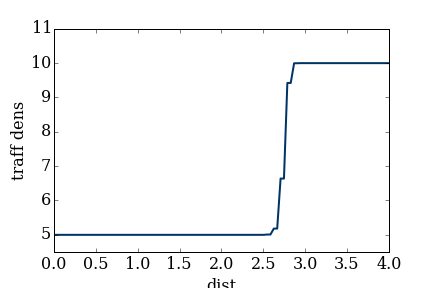
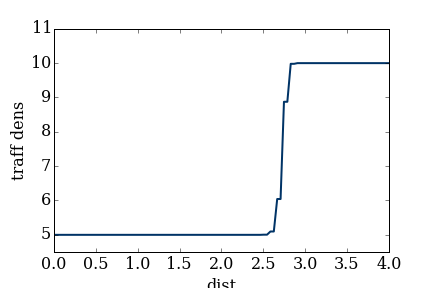
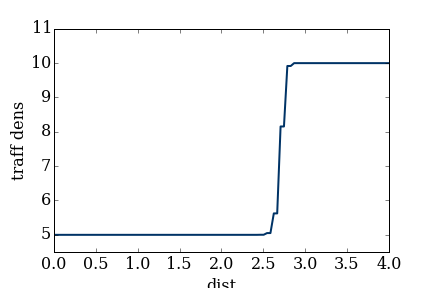
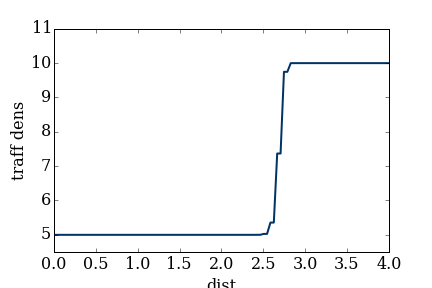
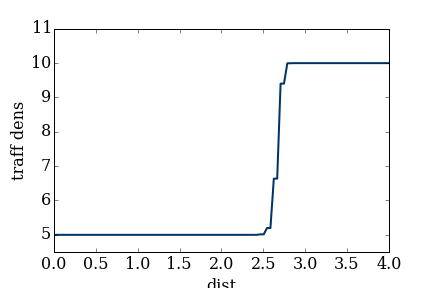
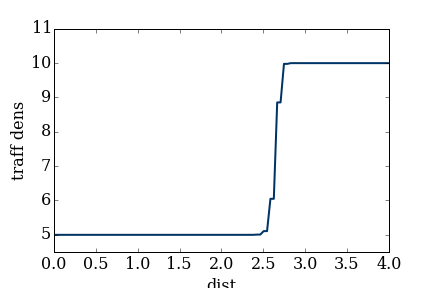
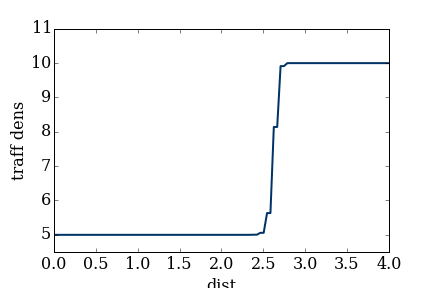
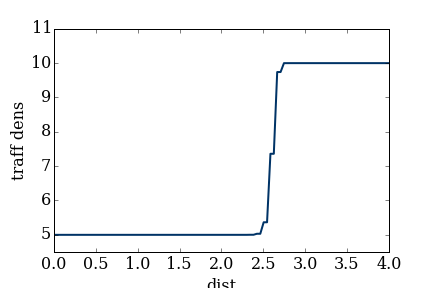
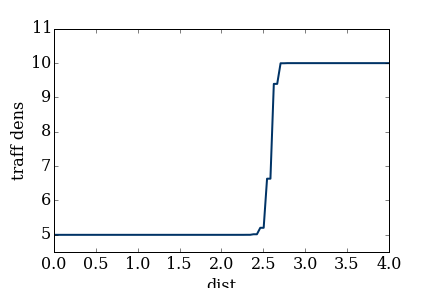
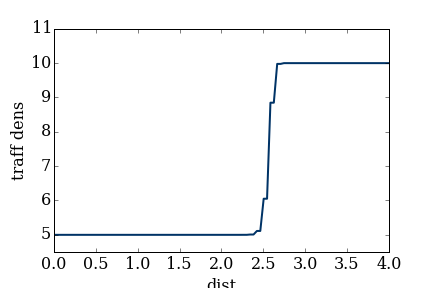
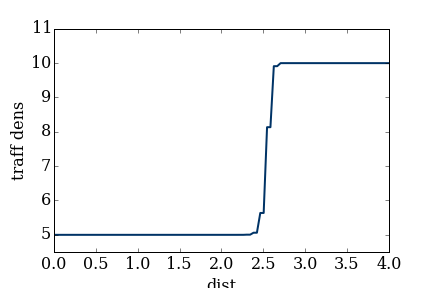
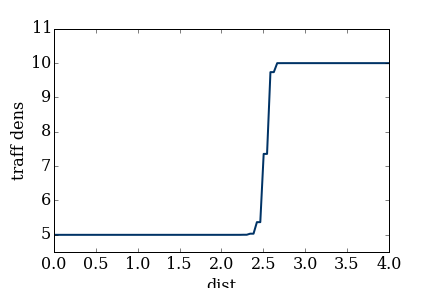
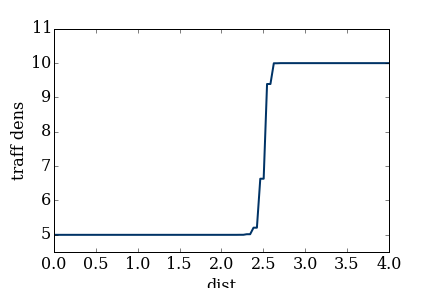
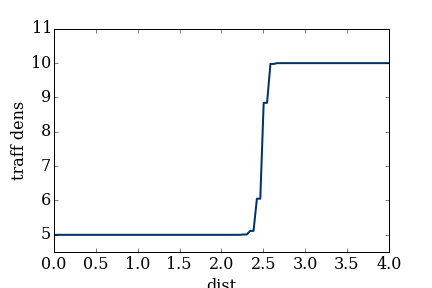
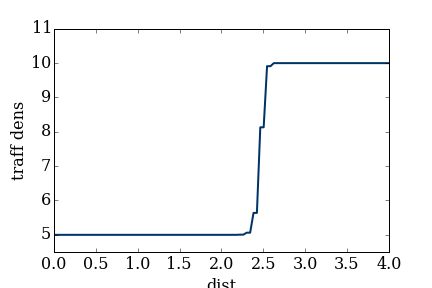
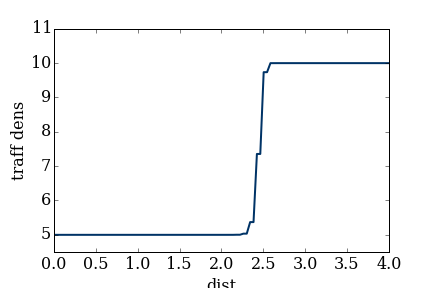
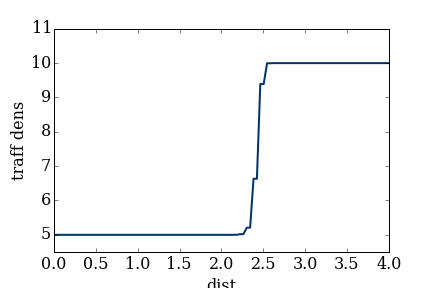
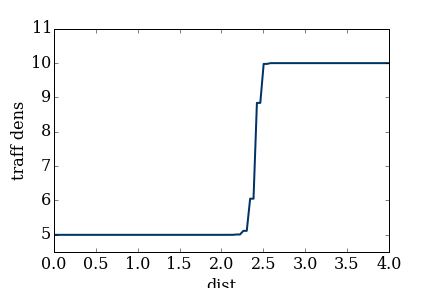
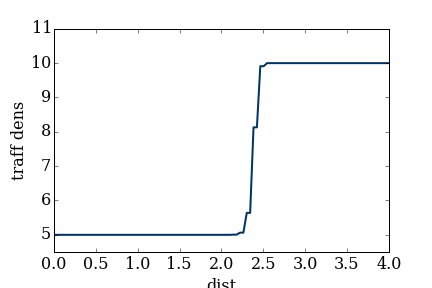

In [8]:
fig= pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('dist'),ylabel=('traff dens'));
line, = ax.plot([],[],color='#003366', lw=2)

anim = animation.FuncAnimation(fig,animate,frames=rho_n,interval=50)
display_animation(anim,default_mode='once')

In [9]:
def minmod(e,dx):
    sigma = numpy.zeros_like(e)
    de_minus=numpy.ones_like(e)
    de_plus = numpy.ones_like(e)
    de_minus[1:]=(e[1:]-e[:-1])/dx
    de_plus[:-1]=(e[1:]-e[:-1])/dx
    
    for i in range(1,len(e)-1):
        if (de_minus[i]*de_plus[i]<0.0):
            sigma[i]=0.0
        elif (numpy.abs(de_minus[i])<numpy.abs(de_plus[i])):
            sigma[i]=de_minus[i]
        else:
            sigma[i]=de_plus[i]
    return sigma

In [10]:
def muscl(rho,nt,dt,dx,rho_max,V_max):
    rho_n=numpy.zeros((nt,len(rho)))
    rho_n[:,:]=rho.copy()
    
    rho_plus=numpy.zeros_like(rho)
    rho_minus=numpy.zeros_like(rho)
    flux = numpy.zeros_like(rho)
    rho_star=numpy.zeros_like(rho)
    
    for t in range(1,nt):
        sigma=minmod(rho,dx)
        
        rho_left = rho+sigma*dx/2.
        rho_right = rho -sigma*dx/2.
        
        flux_left=computeF(V_max,rho_max,rho_left)
        flux_right = computeF(V_max, rho_max,rho_right)
        #flux i = i + 1/2
        flux[:-1]=0.5*(flux_right[1:]+flux_left[:-1]-dx/dt*\
                      (rho_right[1:]-rho_left[:-1]))
        #rk2 step 1
        rho_star[1:-1]=rho[1:-1]+dt/dx*(flux[:-2]-flux[1:-1])
        rho_star[0] = rho[0]
        rho_star[-1] = rho[-1]
        
        sigma = minmod(rho_star,dx)
        
        rho_left=rho_star+sigma*dx/2.
        rho_right=rho_star-sigma*dx/2.
        
        flux_left=computeF(V_max,rho_max,rho_left)
        flux_reight=computeF(V_max,rho_max,rho_right)
        
        flux[:-1]=0.5*(flux_right[1:]+flux_left[:-1]-dx/dt*\
                      (rho_right[1:]-rho_left[:-1]))
        rho_n[t,1:-1]=0.5*(rho[1:-1]+rho_star[1:-1] +dt/dx*\
                          (flux[:-2] - flux[1:-1]))
        rho_n[t,0]=rho[0]
        rho_n[t,-1]=rho[-1]
        rho = rho_n[t].copy()
        
    return rho_n

In [11]:
sigma=1.
dt = sigma*dx/V_max
rho = rho_red_light(nx-1,rho_max,rho_in)
rho_n = muscl(rho,nt,dt,dx,rho_max,V_max)


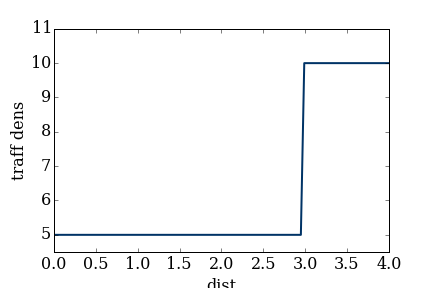
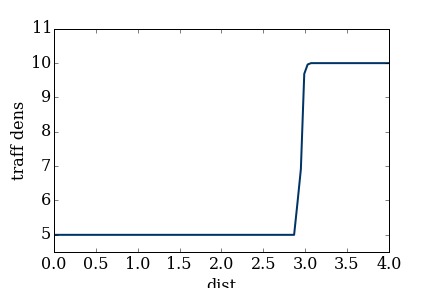
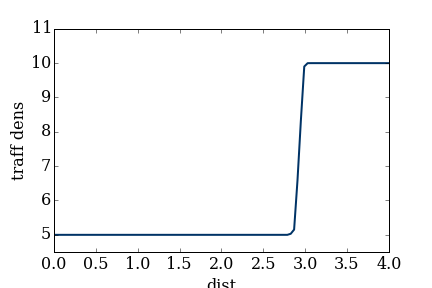
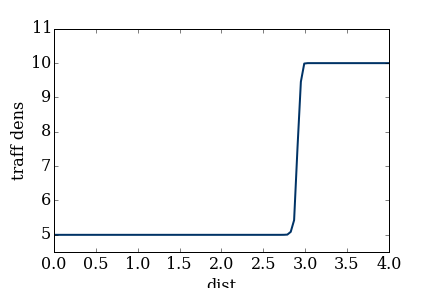
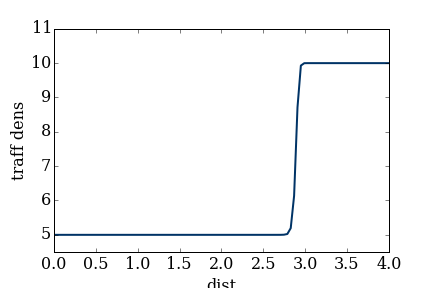
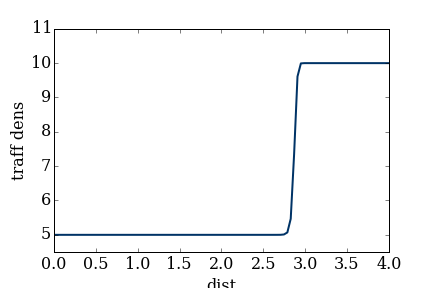
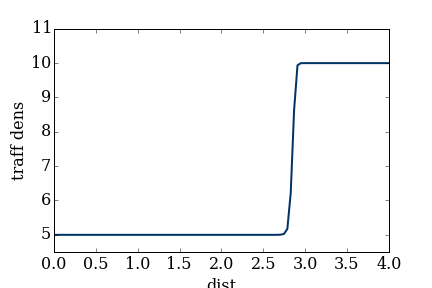
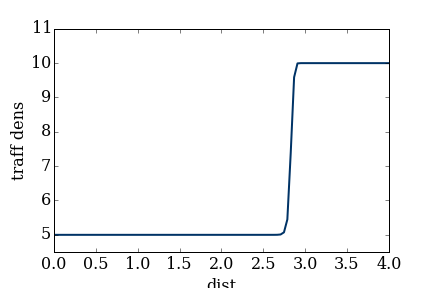
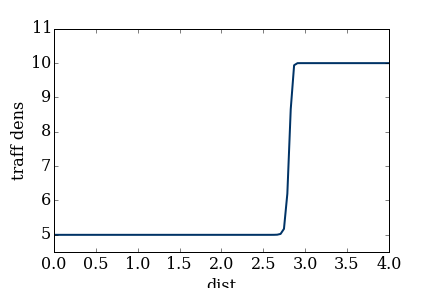
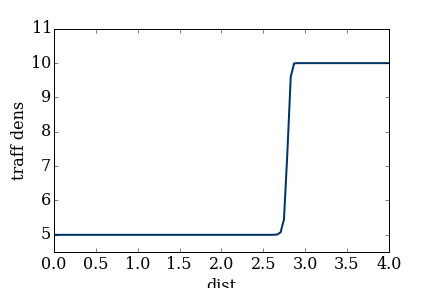
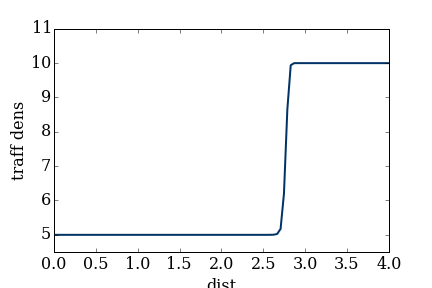
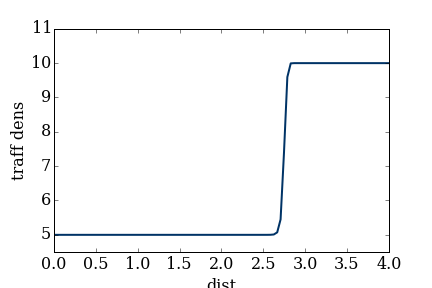
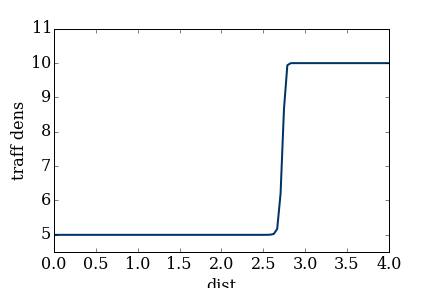
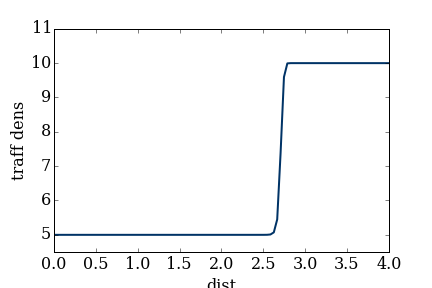
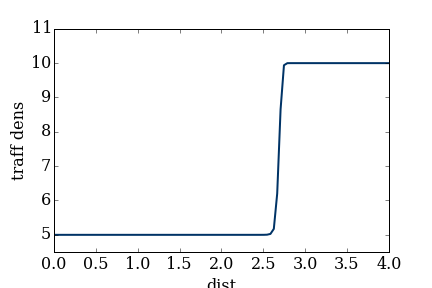
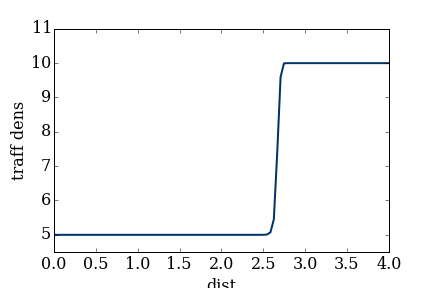
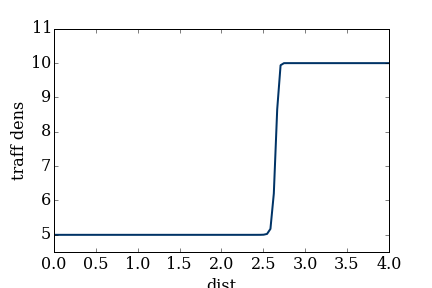
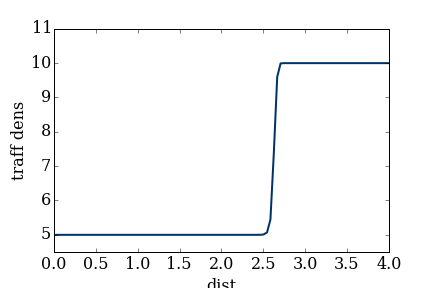
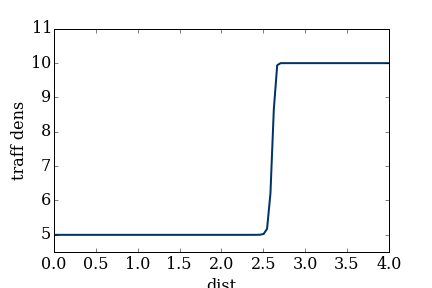
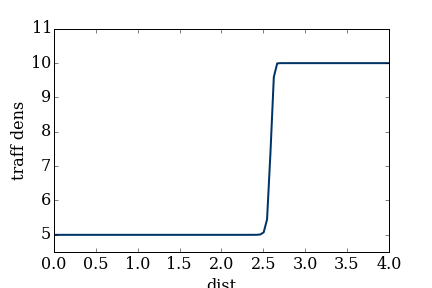
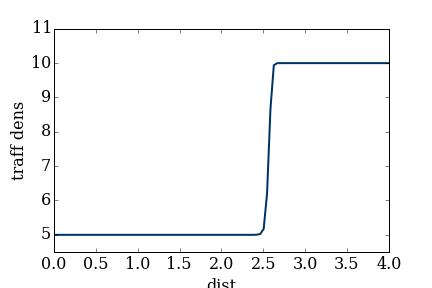
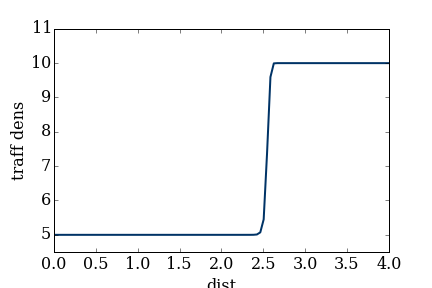
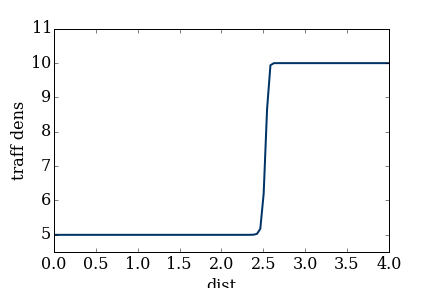
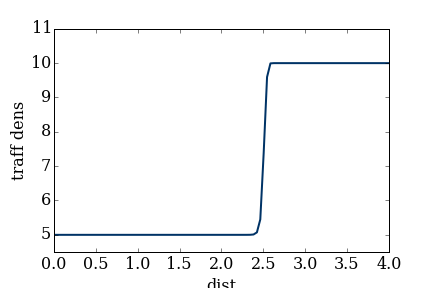
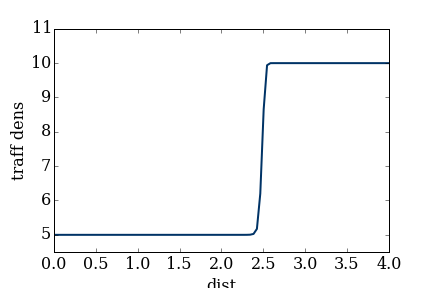
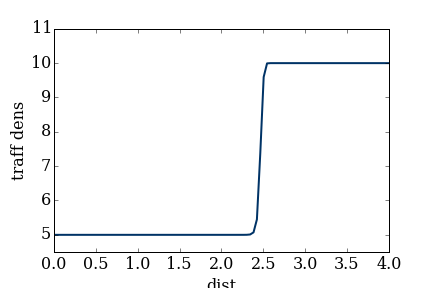
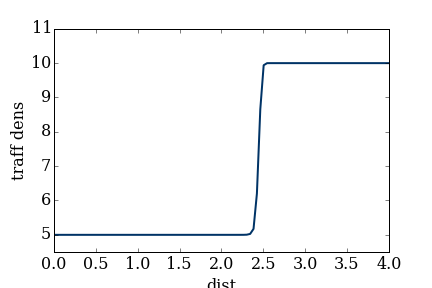
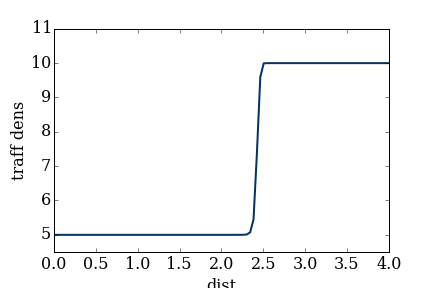
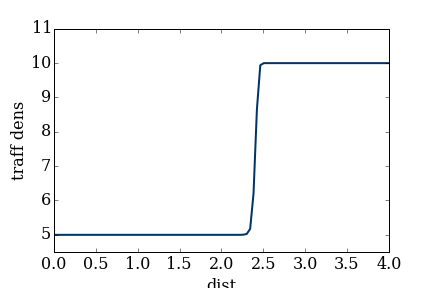
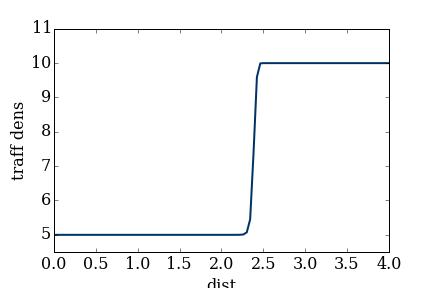

In [12]:
fig = pyplot.figure();
ax = pyplot.axes(xlim=(0,4),ylim=(4.5,11),xlabel=('dist'),ylabel=('traff dens'));
line,=ax.plot([],[],color='#003366', lw=2)

anim = animation.FuncAnimation(fig,animate,frames=rho_n,interval=50)
display_animation(anim,default_mode='once')